In this notebook, we will be building our model for the open-world experiments to multi-class classify 95 monitored website traces with unique labels against additional unmonitored websites.

In [19]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Extracting Data

To begin, we will first import the dataframes into this notebook

In [2]:
with open('datasets/extracted_features.pkl', 'rb') as f:
    extracted_df = pickle.load(f)

In [3]:
extracted_df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,0,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,0,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,0,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,0,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,0,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
28995,-1,4180,413,4593,0.910081,0.089919,1173.380403,2549.414044,32.09,0.006987
28996,-1,4663,447,5110,0.912524,0.087476,1621.869237,3062.015660,38.62,0.007558
28997,-1,302,59,361,0.836565,0.163435,118.245320,179.101695,34.93,0.096759
28998,-1,413,96,509,0.811395,0.188605,166.667122,309.197917,11.84,0.023261


In [4]:
X = extracted_df.drop(columns=['label'])
y = extracted_df['label']

# Feature Importance

In [5]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [6]:
df = pd.DataFrame(X_train)

In [7]:
df.head()

,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
1373,3378,278,3656,0.923961,0.076039,1154.342016,1598.133094,40.09,0.010966
5799,1099,69,1168,0.940925,0.059075,345.411433,595.681159,62.94,0.053887
9637,5731,332,6063,0.945242,0.054758,2115.645547,3282.496988,37.42,0.006172
16404,35,16,51,0.686275,0.313725,15.917267,26.125000,9.19,0.180196
7660,2310,307,2617,0.882690,0.117310,820.464988,1149.498371,31.22,0.011930


In [8]:
clf = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=0)
clf.fit(X_train, y_train)
feature_imp = pd.Series(clf.feature_importances_, index=df.columns).sort_values(ascending=False)

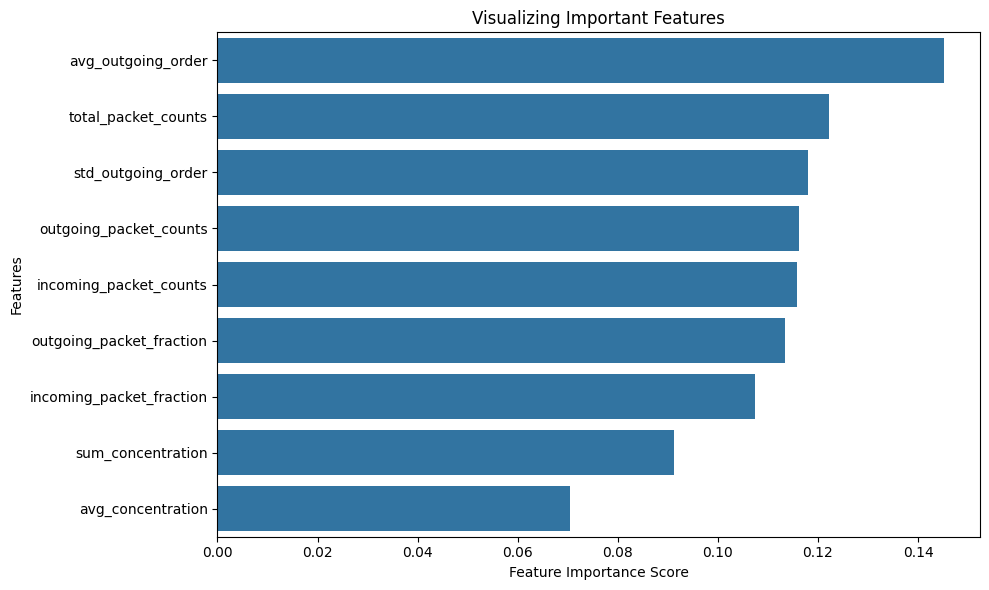

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

Recall the extracted features:
> **Feature Group 1: Traffic Volume (Absolute)**  
> - Feature 1: Number of incoming packets  
> - Feature 2: Number of outgoing packets  
> - Feature 3: Total number of packets  
> 
> **Feature Group 2: Traffic Volume (Fraction)**
> - Feature 1: Number of incoming packets as a fraction of the total number of packets  
> - Feature 2: Number of outgoing packets as a fraction of the total number of packets 
> 
> **Feature Group 3: Traffic Ordering List**
> - Feature 6: Standard deviation of the outgoing packets ordering list  
> - Feature 7: Average of the outgoing packets ordering list  
> 
> **Feature Group 4: Traffic concentration** 
> - Feature 8: Sum of all items in the alternative concentration feature list  
> - Feature 9: Average of all items in the alternative concentration feature list  

We noted that within each of the 4 feature groups, the features are likely to be highly correlated due to their similarity. Furthermore, feature groups 1 and 2 are closely related as well with 1 being an absolute measurement of traffic volume and 2 as the ratio. Hence we will be selecting 2 features from the combination of group 1 and 2, and 1 feature each from group 3 and 4.

According to our feature importance analysis, we have selected the features to be
1. Feature 2: Number of outgoing packets   
2. Feature 3: Total number of packets
3. Feature 7: Average of the outgoing packets ordering list 
4. Feature 8: Sum of all items in the alternative concentration feature list  

In [10]:
X = extracted_df[['outgoing_packet_counts', 'total_packet_counts', 'avg_outgoing_order', 'sum_concentration']]
y = extracted_df['label']

# Constructing Model

In this section, we construct an arbitrary random forest classification model using arbitrarily chosen parameters. This section aims to explore the implementation of the model. These parameters will be tuned in the next section. 

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [12]:
df = pd.DataFrame(X_train)

In [13]:
df.head()

,outgoing_packet_counts,total_packet_counts,avg_outgoing_order,sum_concentration
1373,278,3656,1598.133094,40.09
5799,69,1168,595.681159,62.94
9637,332,6063,3282.496988,37.42
16404,16,51,26.125000,9.19
7660,307,2617,1149.498371,31.22


In [14]:
clf = RandomForestClassifier(n_estimators=100, criterion="entropy", random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=0)

In [15]:
y_test_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_test_pred)
confusion_mat = confusion_matrix(y_test, y_test_pred)

print(f"Accuracy: \n{accuracy} \n\nConfusion Matrix: \n{confusion_mat}")

Accuracy: 
0.6553448275862069 

Confusion Matrix: 
[[1679    6    3 ...    4    1    4]
 [   6   19    0 ...    0    0    0]
 [  10    0   13 ...    1    0    0]
 ...
 [  18    0    0 ...    9    0    1]
 [   1    0    0 ...    0   33    0]
 [  27    0    0 ...    1    0   13]]


# Model Tuning

In [16]:
param_grid_random = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=0), param_distributions=param_grid_random, n_iter=50, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_random_params = random_search.best_params_
print("Best parameters from RandomizedSearchCV:", best_random_params)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\betti\Desktop\Bettina\School\ntu\y3s1 - exchange\Machine Learning\team project\github\neurotic_networkers\.venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters from RandomizedSearchCV: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}


In [17]:
param_grid = {
    'n_estimators': [150, 200, 250],       
    'max_depth': [None],              
    'min_samples_split': [1, 2, 3],              
    'min_samples_leaf': [1],            
    'max_features': ['sqrt'],    
    'bootstrap': [True],                   
    'criterion': ['entropy'],            
}

grid = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=param_grid, refit=True, verbose = 3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=150;, score=nan total time=   0.0s
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=150;, score=nan total time=   0.0s
[CV 3/5] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=150;, score=nan total time=   0.0s
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=150;, score=nan total time=   0.0s
[CV 5/5] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=1, n_estimators=150;, score=nan total time=   0.0s
[CV 1/5] END bootstrap=True, criterion=entropy, max_depth=None, max_features=sqr

c:\Users\betti\Desktop\Bettina\School\ntu\y3s1 - exchange\Machine Learning\team project\github\neurotic_networkers\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\betti\Desktop\Bettina\School\ntu\y3s1 - exchange\Machine Learning\team project\github\neurotic_networkers\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\betti\Desktop\Bettina\School\ntu\y3s1 - exchange\Machine Learning\team project\github\neurotic_networ

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'bootstrap': [True], 'criterion': ['entropy'],
                         'max_depth': [None], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [150, 200, 250]},
             verbose=3)

In [20]:
# print best parameters after grid search
print(grid.best_params_)

# print how the best model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 250}
RandomForestClassifier(criterion='entropy', min_samples_split=3,
                       n_estimators=250, random_state=0)


In [21]:
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9999
Test Accuracy: 0.6588


In [22]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

          -1       0.61      0.84      0.70      2044
           0       0.62      0.55      0.58        33
           1       0.63      0.30      0.41        40
           2       0.79      0.67      0.72        39
           3       0.75      0.56      0.64        32
           4       0.74      0.72      0.73        43
           5       0.74      0.59      0.66        44
           6       0.84      0.79      0.81        33
           7       0.69      0.45      0.55        44
           8       0.90      0.61      0.73        44
           9       0.51      0.45      0.48        40
          10       0.81      0.50      0.62        42
          11       0.52      0.55      0.54        40
          12       0.83      0.85      0.84        40
          13       0.53      0.46      0.49        37
          14       0.65      0.42      0.51        36
          15       0.77      0.67      0.72        36
          16       0.86    